# LESSON 2.7: Bit-Plane Slicing
## Biomedical Image Processing Techniques

In this lesson:
- Binary representation of pixels
- Extracting bit planes
- Significance of different bit planes
- Image reconstruction from bit planes
- Applications in image compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Binary Representation of Pixel Values

An 8-bit grayscale pixel (0-255) can be expressed as:

$$pixel = a_7 \cdot 2^7 + a_6 \cdot 2^6 + a_5 \cdot 2^5 + a_4 \cdot 2^4 + a_3 \cdot 2^3 + a_2 \cdot 2^2 + a_1 \cdot 2^1 + a_0 \cdot 2^0$$

Where $a_i \in \{0, 1\}$

| Bit | Position | Weight | Significance |
|-----|----------|--------|-------------|
| $a_7$ | MSB | 128 | Most Significant |
| $a_6$ | | 64 | |
| $a_5$ | | 32 | |
| $a_4$ | | 16 | |
| $a_3$ | | 8 | |
| $a_2$ | | 4 | |
| $a_1$ | | 2 | |
| $a_0$ | LSB | 1 | Least Significant |

## 2. Extracting Bit Planes

To extract bit plane $n$ (0-7):

$$bitplane_n = (image \gg n) \& 1$$

Or equivalently:
$$bitplane_n = (image \& 2^n) \gg n$$

In [3]:
def extract_bitplane(image, plane):
    """
    Extract a specific bit plane from an image.
    
    Parameters:
    - image: input grayscale image (uint8)
    - plane: bit plane number (0=LSB, 7=MSB)
    
    Returns:
    - bit plane as binary image (0 or 255)
    """
    # Extract the bit at position 'plane'
    bitplane = (image >> plane) & 1
    
    # Scale to 0-255 for visualization
    return (bitplane * 255).astype(np.uint8)

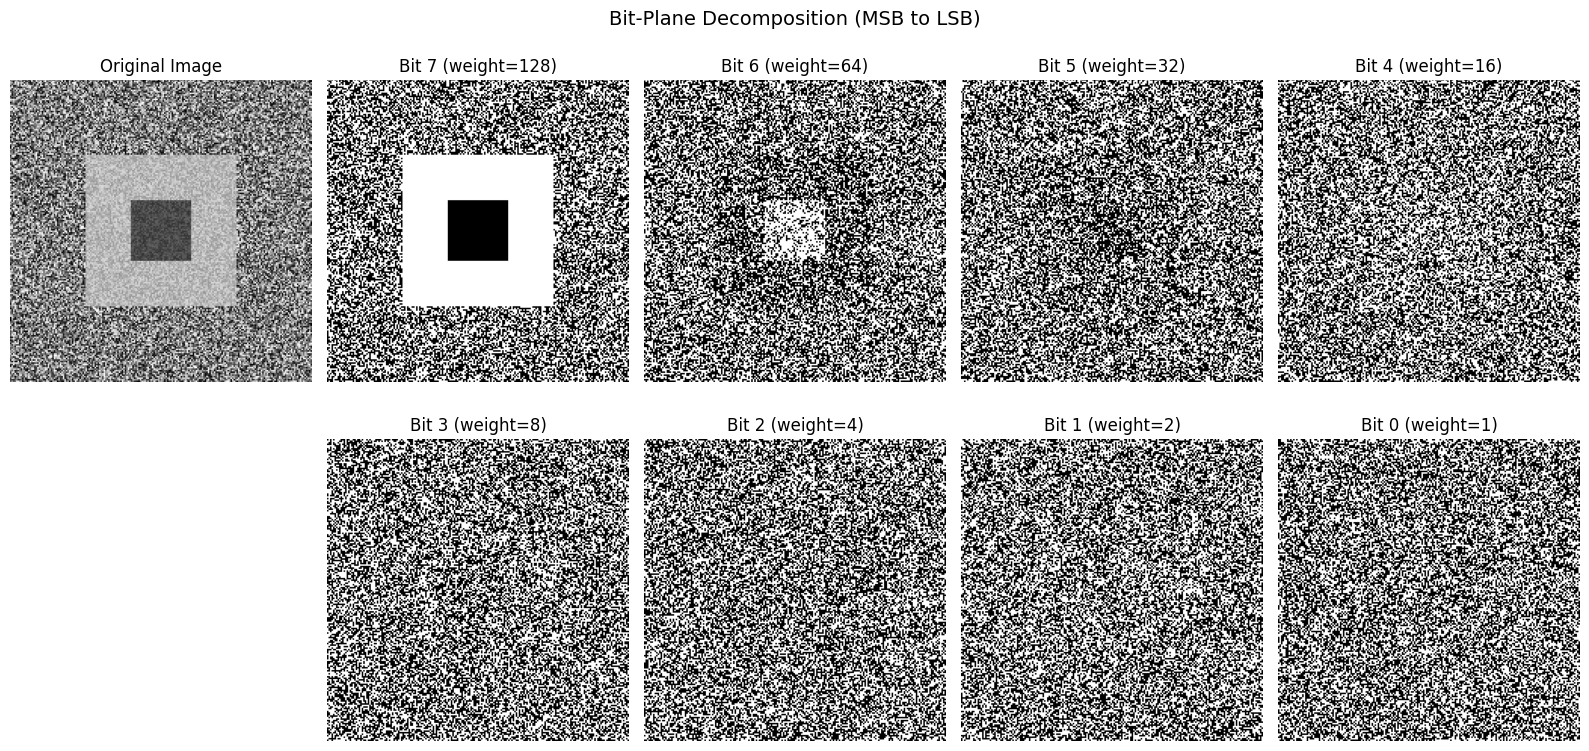

In [4]:
# Create a test image
np.random.seed(42)
test_image = np.random.randint(0, 256, (200, 200), dtype=np.uint8)

# Add some structure
test_image[50:150, 50:150] = np.random.randint(150, 220, (100, 100), dtype=np.uint8)
test_image[80:120, 80:120] = np.random.randint(50, 100, (40, 40), dtype=np.uint8)

# Extract all 8 bit planes
bitplanes = [extract_bitplane(test_image, i) for i in range(8)]

# Visualize
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(2, 5, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Bit planes (from MSB to LSB)
for i in range(8):
    plt.subplot(2, 5, i+2 if i < 4 else i+3)
    plt.imshow(bitplanes[7-i], cmap='gray')
    weight = 2**(7-i)
    plt.title(f'Bit {7-i} (weight={weight})')
    plt.axis('off')

plt.suptitle('Bit-Plane Decomposition (MSB to LSB)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Significance of Bit Planes

**Observation:**
- **Higher-order bits** (7, 6, 5, 4): Contain most image structure
- **Lower-order bits** (3, 2, 1, 0): Appear more random/noisy

This is because:
- Bit 7 contributes 128 to pixel value
- Bit 0 only contributes 1 to pixel value

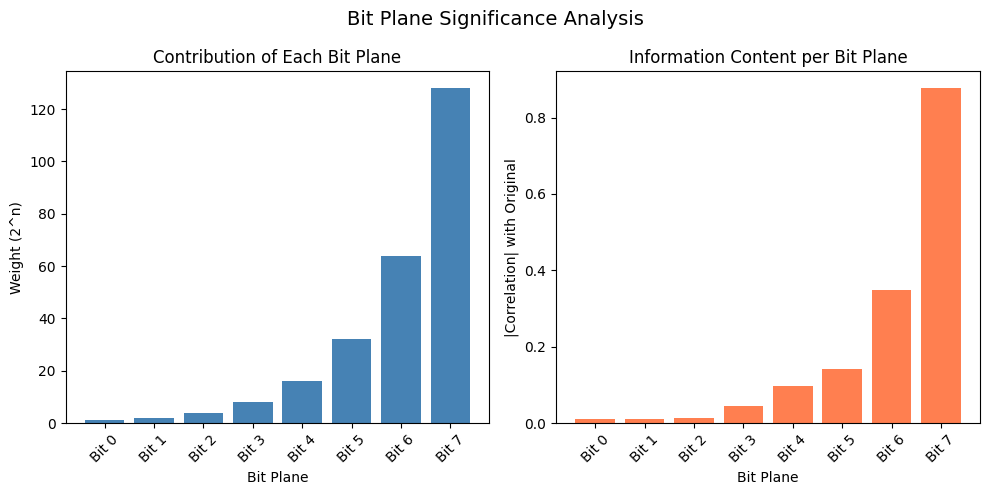

In [5]:
# Calculate correlation with original image for each bit plane
correlations = []

for i in range(8):
    # Normalize for correlation
    orig_norm = (test_image - test_image.mean()) / test_image.std()
    bp_norm = (bitplanes[i]/255.0 - 0.5) / 0.5
    
    corr = np.corrcoef(orig_norm.ravel(), bp_norm.ravel())[0, 1]
    correlations.append(corr)

# Plot correlations
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
weights = [2**i for i in range(8)]
plt.bar(range(8), weights, color='steelblue')
plt.xlabel('Bit Plane')
plt.ylabel('Weight (2^n)')
plt.title('Contribution of Each Bit Plane')
plt.xticks(range(8), [f'Bit {i}' for i in range(8)], rotation=45)

plt.subplot(1, 2, 2)
plt.bar(range(8), [abs(c) for c in correlations], color='coral')
plt.xlabel('Bit Plane')
plt.ylabel('|Correlation| with Original')
plt.title('Information Content per Bit Plane')
plt.xticks(range(8), [f'Bit {i}' for i in range(8)], rotation=45)

plt.suptitle('Bit Plane Significance Analysis', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Image Reconstruction from Bit Planes

We can reconstruct the image using only selected bit planes:

$$image = \sum_{i \in selected} bitplane_i \cdot 2^i$$

In [6]:
def reconstruct_image(bitplanes_list, planes_to_use):
    """
    Reconstruct image from selected bit planes.
    
    Parameters:
    - bitplanes_list: list of 8 bit planes (each 0 or 255)
    - planes_to_use: list of plane indices to use (0-7)
    
    Returns:
    - reconstructed image
    """
    result = np.zeros_like(bitplanes_list[0], dtype=np.uint16)
    
    for plane in planes_to_use:
        # Convert back to 0/1 and apply weight
        bit_values = bitplanes_list[plane] // 255
        result += bit_values * (2 ** plane)
    
    return result.astype(np.uint8)

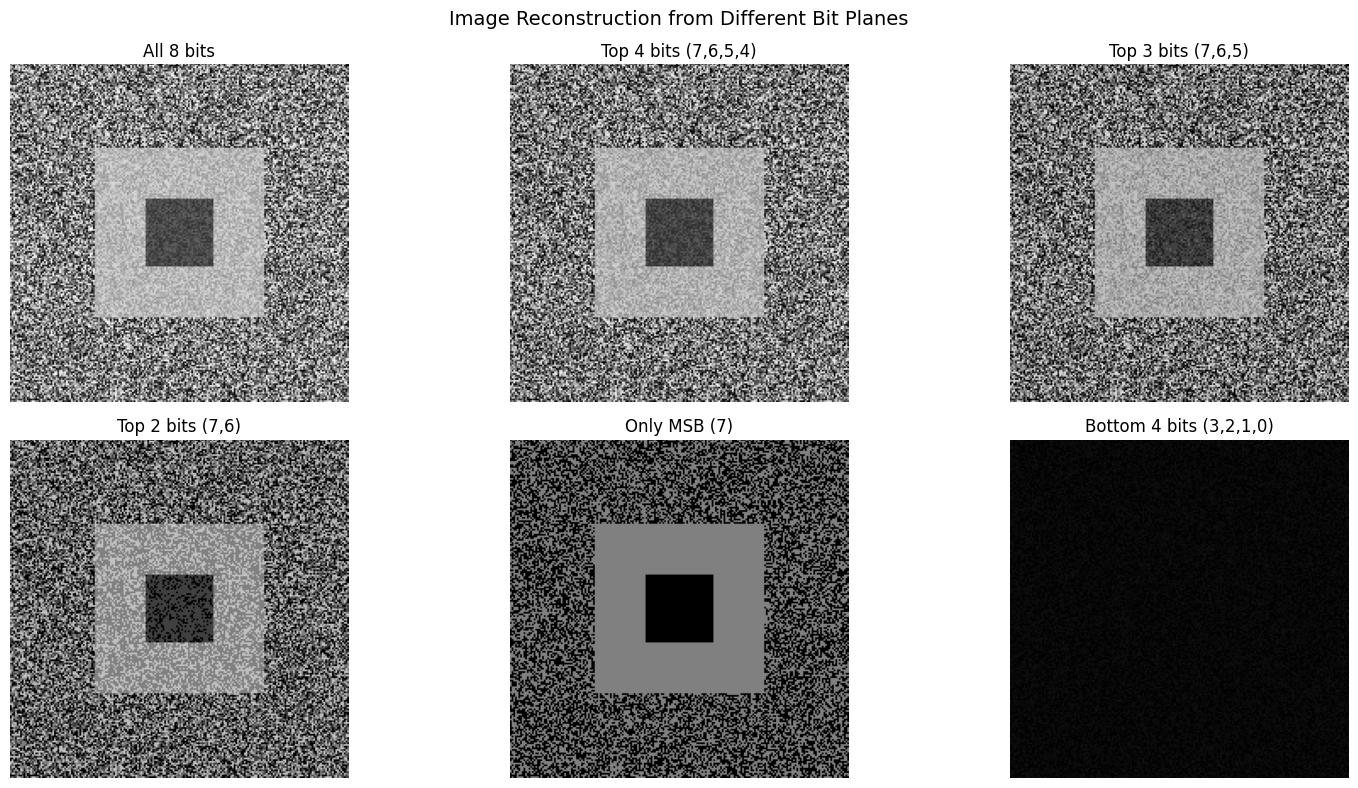

In [7]:
# Reconstruct using different combinations of bit planes
reconstructions = {
    'All 8 bits': list(range(8)),
    'Top 4 bits (7,6,5,4)': [7, 6, 5, 4],
    'Top 3 bits (7,6,5)': [7, 6, 5],
    'Top 2 bits (7,6)': [7, 6],
    'Only MSB (7)': [7],
    'Bottom 4 bits (3,2,1,0)': [3, 2, 1, 0]
}

plt.figure(figsize=(16, 8))

for i, (name, planes) in enumerate(reconstructions.items()):
    plt.subplot(2, 3, i+1)
    recon = reconstruct_image(bitplanes, planes)
    plt.imshow(recon, cmap='gray', vmin=0, vmax=255)
    plt.title(f'{name}')
    plt.axis('off')

plt.suptitle('Image Reconstruction from Different Bit Planes', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Progressive Reconstruction

Adding bit planes one by one from MSB to LSB.

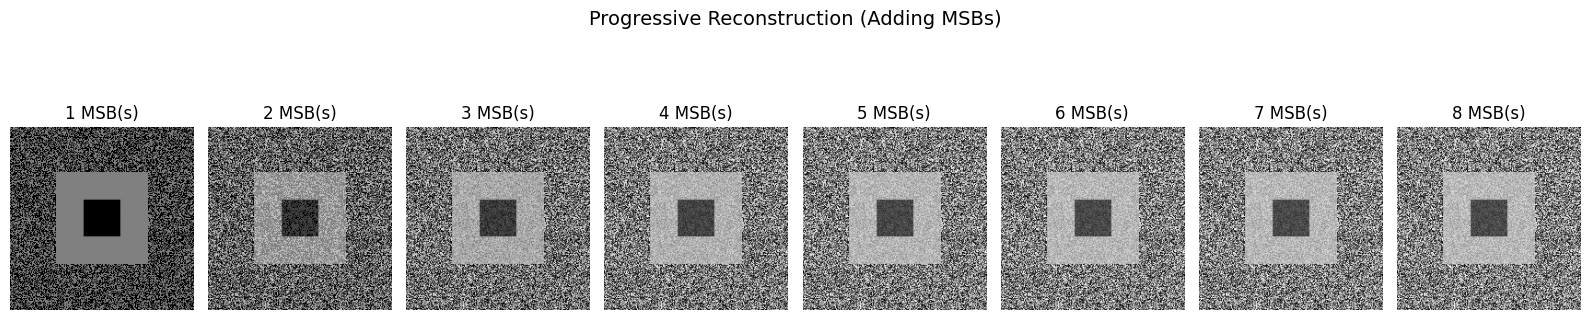

In [8]:
# Progressive reconstruction from MSB
plt.figure(figsize=(16, 4))

for i in range(8):
    plt.subplot(1, 8, i+1)
    planes = list(range(7, 7-i-1, -1))  # [7], [7,6], [7,6,5], etc.
    recon = reconstruct_image(bitplanes, planes)
    plt.imshow(recon, cmap='gray', vmin=0, vmax=255)
    plt.title(f'{i+1} MSB(s)')
    plt.axis('off')

plt.suptitle('Progressive Reconstruction (Adding MSBs)', fontsize=14)
plt.tight_layout()
plt.show()

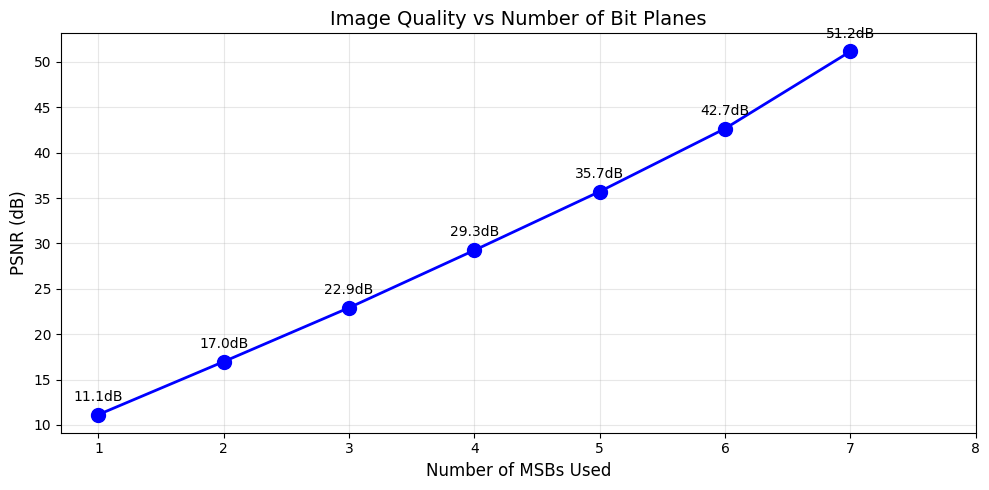

In [9]:
# Calculate PSNR for each reconstruction
def psnr(original, reconstructed):
    """Calculate Peak Signal-to-Noise Ratio."""
    mse = np.mean((original.astype(float) - reconstructed.astype(float)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(255**2 / mse)

# Calculate PSNR for progressive reconstruction
psnr_values = []
bits_used = []

for i in range(8):
    planes = list(range(7, 7-i-1, -1))
    recon = reconstruct_image(bitplanes, planes)
    psnr_val = psnr(test_image, recon)
    psnr_values.append(psnr_val)
    bits_used.append(i + 1)

plt.figure(figsize=(10, 5))
plt.plot(bits_used, psnr_values, 'bo-', markersize=10, linewidth=2)
plt.xlabel('Number of MSBs Used', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.title('Image Quality vs Number of Bit Planes', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(bits_used)

# Annotate
for i, (x, y) in enumerate(zip(bits_used, psnr_values)):
    plt.annotate(f'{y:.1f}dB', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## 6. Application: Image Compression

Since lower bit planes contain mostly noise:
- We can **discard LSBs** to reduce storage
- 4 MSBs often provide acceptable quality
- This is a form of **lossy compression**

In [10]:
def compress_to_n_bits(image, n_bits):
    """
    Compress image by keeping only top n bits.
    
    Parameters:
    - image: input image (uint8)
    - n_bits: number of MSBs to keep (1-8)
    
    Returns:
    - compressed image
    """
    # Shift right to remove LSBs, then shift left and scale
    shift = 8 - n_bits
    compressed = (image >> shift) << shift
    
    # Scale to full range for better visualization
    # (Optional: remove this line to see actual values)
    # compressed = (compressed >> shift) * (255 // (2**n_bits - 1))
    
    return compressed.astype(np.uint8)

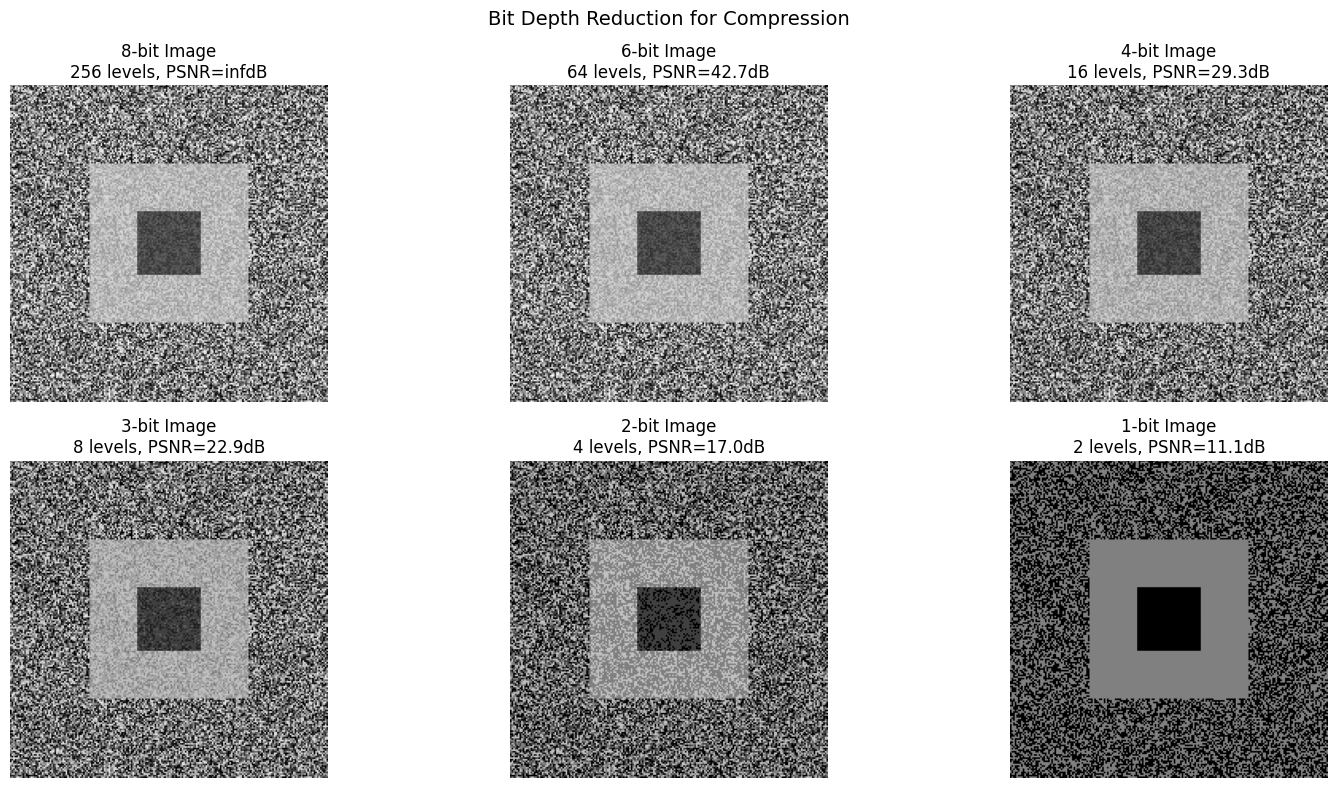

In [11]:
# Compare different bit depths
bit_depths = [8, 6, 4, 3, 2, 1]

plt.figure(figsize=(16, 8))

for i, n_bits in enumerate(bit_depths):
    plt.subplot(2, 3, i+1)
    compressed = compress_to_n_bits(test_image, n_bits)
    plt.imshow(compressed, cmap='gray', vmin=0, vmax=255)
    
    # Calculate stats
    unique_values = len(np.unique(compressed))
    compression_ratio = 8 / n_bits
    psnr_val = psnr(test_image, compressed)
    
    plt.title(f'{n_bits}-bit Image\n{unique_values} levels, PSNR={psnr_val:.1f}dB')
    plt.axis('off')

plt.suptitle('Bit Depth Reduction for Compression', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Application: Watermarking (LSB Embedding)

Since LSB has minimal visual impact, we can hide data there.

**LSB Watermarking:**
- Replace LSB with watermark bits
- Visually imperceptible
- Used for copyright protection

In [12]:
def embed_watermark(image, watermark):
    """
    Embed watermark in LSB of image.
    
    Parameters:
    - image: cover image (uint8)
    - watermark: binary watermark (0 or 255)
    
    Returns:
    - watermarked image
    """
    # Clear LSB of image
    cleared = image & 0xFE  # AND with 11111110
    
    # Add watermark as LSB
    watermark_bit = (watermark > 127).astype(np.uint8)
    watermarked = cleared | watermark_bit
    
    return watermarked

def extract_watermark(watermarked_image):
    """
    Extract watermark from LSB.
    """
    return ((watermarked_image & 1) * 255).astype(np.uint8)

In [13]:
# Create a watermark pattern
watermark = np.zeros((200, 200), dtype=np.uint8)
watermark[80:120, 60:140] = 255  # Rectangle

# Add text-like pattern
watermark[90:110, 70:75] = 255  # C
watermark[90:95, 75:85] = 255
watermark[105:110, 75:85] = 255

watermark[90:110, 95:100] = 255  # O
watermark[90:95, 100:110] = 255
watermark[105:110, 95:110] = 255
watermark[90:110, 110:115] = 255

watermark[90:110, 125:130] = 255  # P
watermark[90:95, 130:135] = 255
watermark[97:102, 125:135] = 255

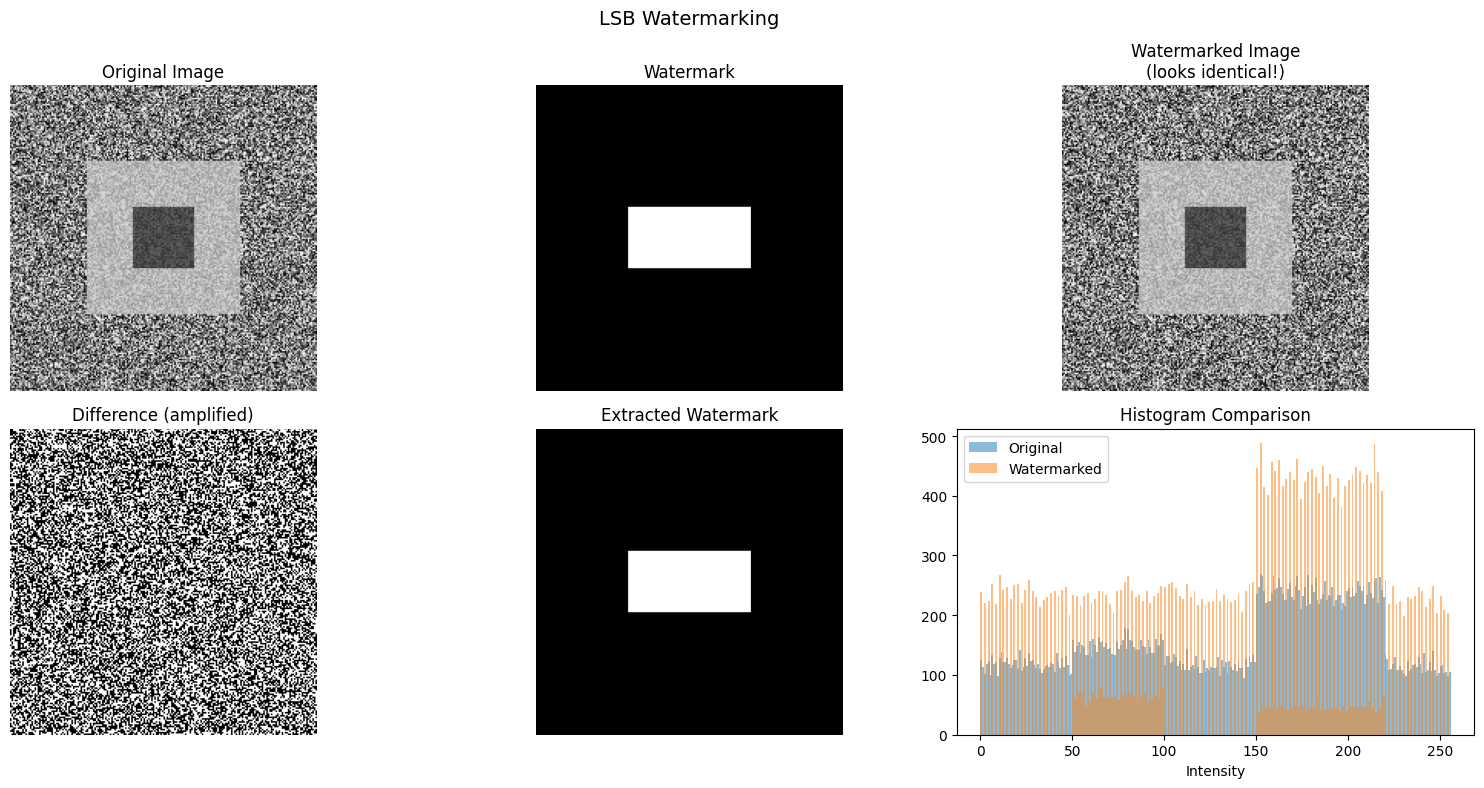

PSNR between original and watermarked: 51.14 dB
Max pixel difference: 1


In [14]:
# Embed and extract watermark
watermarked = embed_watermark(test_image, watermark)
extracted = extract_watermark(watermarked)

plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(watermark, cmap='gray')
plt.title('Watermark')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(watermarked, cmap='gray')
plt.title('Watermarked Image\n(looks identical!)')
plt.axis('off')

plt.subplot(2, 3, 4)
diff = np.abs(test_image.astype(int) - watermarked.astype(int))
plt.imshow(diff * 128, cmap='gray')  # Amplify for visibility
plt.title('Difference (amplified)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(extracted, cmap='gray')
plt.title('Extracted Watermark')
plt.axis('off')

plt.subplot(2, 3, 6)
# Show histogram comparison
plt.hist(test_image.ravel(), bins=256, range=(0, 256), alpha=0.5, label='Original')
plt.hist(watermarked.ravel(), bins=256, range=(0, 256), alpha=0.5, label='Watermarked')
plt.xlabel('Intensity')
plt.legend()
plt.title('Histogram Comparison')

plt.suptitle('LSB Watermarking', fontsize=14)
plt.tight_layout()
plt.show()

print(f"PSNR between original and watermarked: {psnr(test_image, watermarked):.2f} dB")
print(f"Max pixel difference: {diff.max()}")

## 8. Medical Application: Analyzing Bit Plane Information

In [15]:
# Create simulated medical image (ultrasound-like)
np.random.seed(789)
from scipy.ndimage import gaussian_filter

# Base tissue
medical = np.random.randint(60, 100, (200, 200), dtype=np.uint8)

# Add structures
y, x = np.ogrid[:200, :200]

# Organ outline
organ = ((x - 100)**2 / 60**2 + (y - 100)**2 / 70**2) <= 1
medical[organ] = np.random.randint(80, 120, medical[organ].shape)

# Lesion (brighter)
lesion = ((x - 120)**2 + (y - 90)**2) <= 15**2
medical[lesion] = np.random.randint(140, 180, medical[lesion].shape)

# Apply speckle-like noise (characteristic of ultrasound)
medical = gaussian_filter(medical, sigma=1).astype(np.uint8)
noise = np.random.rayleigh(10, medical.shape)
medical = np.clip(medical + noise, 0, 255).astype(np.uint8)

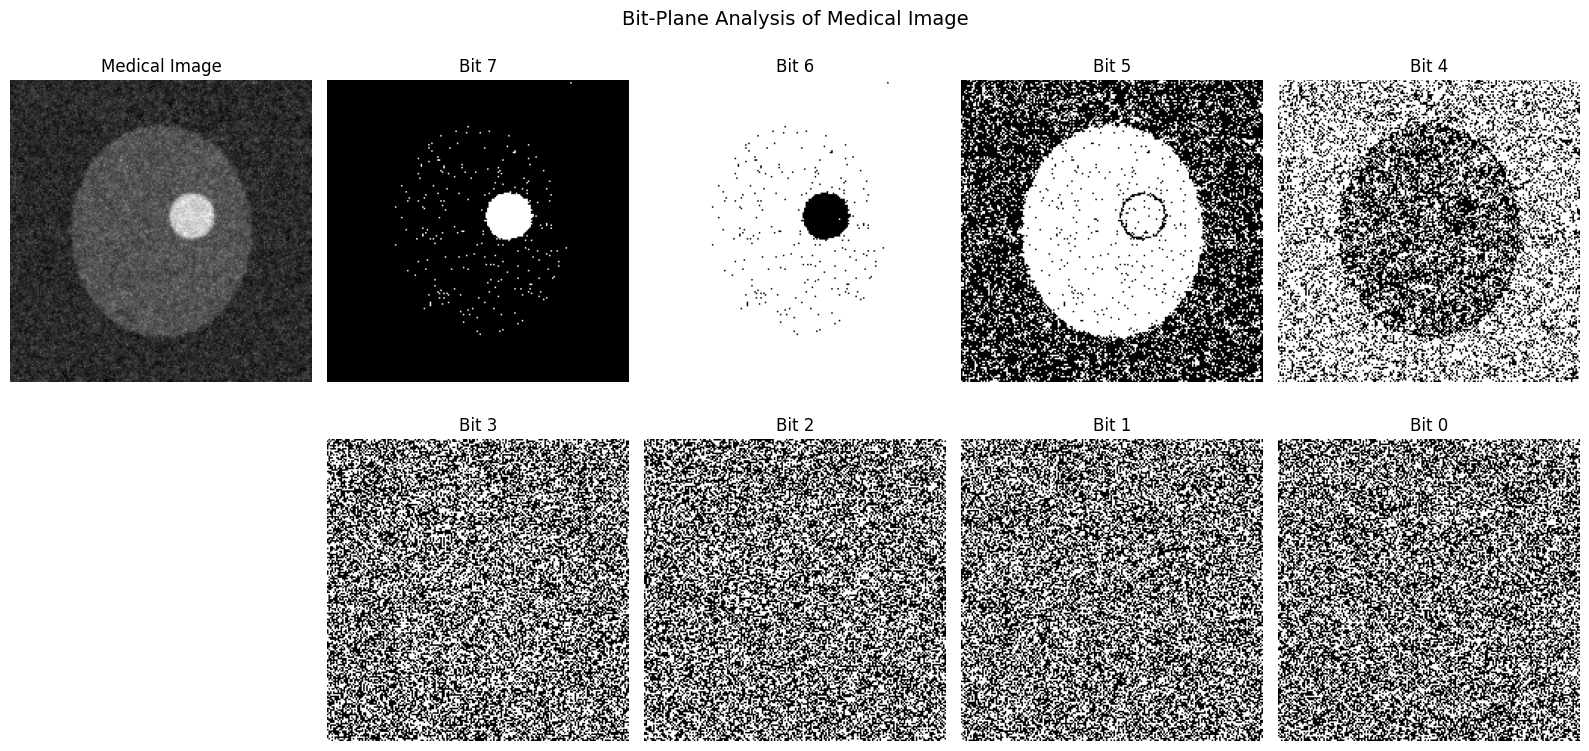

In [16]:
# Analyze bit planes of medical image
med_bitplanes = [extract_bitplane(medical, i) for i in range(8)]

plt.figure(figsize=(16, 8))

plt.subplot(2, 5, 1)
plt.imshow(medical, cmap='gray')
plt.title('Medical Image')
plt.axis('off')

for i in range(8):
    plt.subplot(2, 5, i+2 if i < 4 else i+3)
    plt.imshow(med_bitplanes[7-i], cmap='gray')
    plt.title(f'Bit {7-i}')
    plt.axis('off')

plt.suptitle('Bit-Plane Analysis of Medical Image', fontsize=14)
plt.tight_layout()
plt.show()

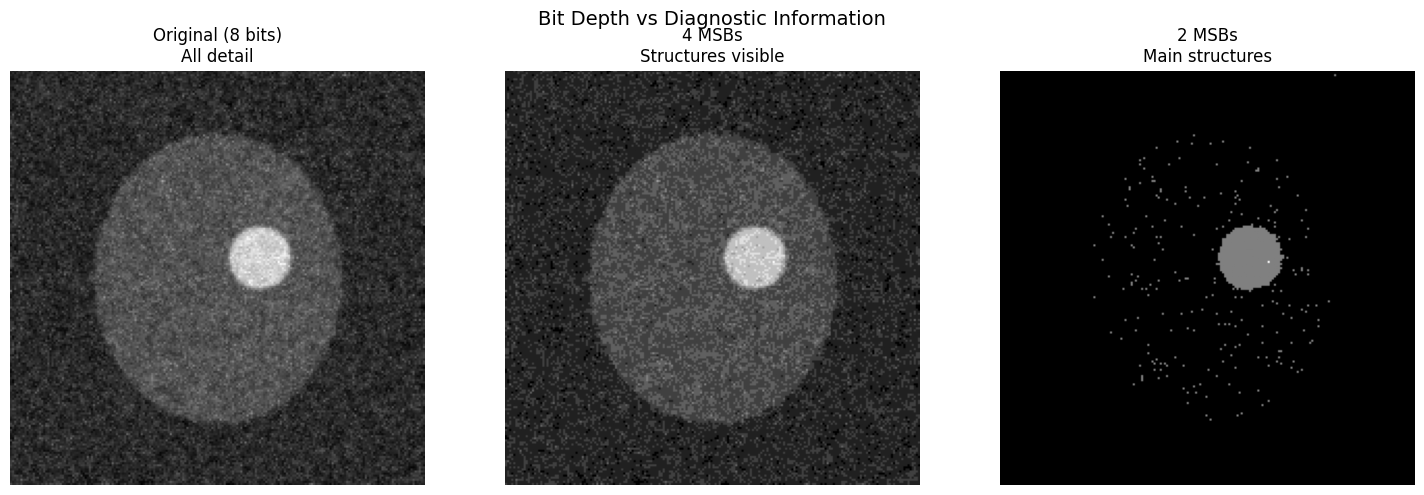

In [17]:
# Show that MSBs capture the important diagnostic information
med_4bit = reconstruct_image(med_bitplanes, [7, 6, 5, 4])
med_2bit = reconstruct_image(med_bitplanes, [7, 6])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(medical, cmap='gray')
plt.title('Original (8 bits)\nAll detail')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(med_4bit, cmap='gray')
plt.title('4 MSBs\nStructures visible')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(med_2bit, cmap='gray')
plt.title('2 MSBs\nMain structures')
plt.axis('off')

plt.suptitle('Bit Depth vs Diagnostic Information', fontsize=14)
plt.tight_layout()
plt.show()

## Summary

What we learned:

1. **Binary Representation**: 8-bit pixel = sum of 8 bit planes weighted by powers of 2

2. **Bit Plane Extraction**: $bitplane_n = (image \gg n) \& 1$

3. **Significance**:
   - MSBs (7,6,5,4): Contain image structure
   - LSBs (3,2,1,0): Contain fine detail/noise

4. **Applications**:
   - **Compression**: Discard LSBs to reduce data
   - **Watermarking**: Hide data in LSB
   - **Analysis**: Understand image information distribution

5. **Medical Imaging**: 4-5 MSBs often sufficient for diagnostic content